# DT Assignment

# Data Loading

In [1]:
import pandas as pd 
import numpy as np

In [2]:
pd_data = pd.read_csv('https://raw.githubusercontent.com/AugustLONG/ML01/master/01decisiontree/AllElectronics.csv')
pd_data.drop("RID",axis=1, inplace = True) #RID는 그냥 순서라서 삭제
pd_data

,age,income,student,credit_rating,class_buys_computer
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
2,middle_aged,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes
5,senior,low,yes,excellent,no
6,middle_aged,low,yes,excellent,yes
7,youth,medium,no,fair,no
8,youth,low,yes,fair,yes
9,senior,medium,yes,fair,yes


## Gini 계수를 구하는 함수 만들기

<img src="gini.png" width="200">

- Input: df(데이터), label(타겟변수명)
- 해당 결과는 아래와 같이 나와야 합니다.

- 지니계수는 데이터의 통계적 분산 정도를 정량화 해서 표현한 값이다.
- 어떤 집합의 gini index가 높을수록 그 집단의 데이터가 분산되어 있음을 확인할 수 있다.

In [3]:
def get_gini(df, label):
    gini = 1
    percentage = df[label].value_counts() / len(df)
    for p in percentage:
        gini -= p**2
        
    return gini

In [4]:
get_gini(pd_data,'class_buys_computer')

0.4591836734693877

## Feature의 Class를 이진 분류로 만들기
- ex) {A,B,C} -> ({A}, {B,C}), ({B}, {A,C}), ({C}, {A,B})

- Input: df(데이터), attribute(Gini index를 구하고자 하는 변수명)
- Income 변수를 결과로 출력해주세요.

In [5]:
from itertools import combinations

def get_binary_split(df, attribute):
    
    uniques = list(df[attribute].unique()) # 속성 데이터 고유값들을 담은 리스트 
    result=[]
    len_uniques = len(uniques)
    for i in range(len_uniques - 1):
        for j in list(combinations(uniques, i+1)):
            result.append(list(j))
    
    return result

In [6]:
get_binary_split(pd_data,'income')

[['high'],
 ['medium'],
 ['low'],
 ['high', 'medium'],
 ['high', 'low'],
 ['medium', 'low']]

## 모든 이진분류의 경우의 Gini index를 구하는 함수 만들기
- 위에서 완성한 두 함수를 사용하여 만들어주세요!
- 해당 결과는 아래와 같이 나와야 합니다.

In [7]:
def get_attribute_gini_index(df, attribute, label):
    
    result = {}
    binary_split = get_binary_split(df, attribute)
    n = len(df)
    for i in binary_split:
        key = '_'.join(i)
        df_1 = df[df[attribute].isin(i)] # binary split 중 i를 포함한 경우
        df_2 = df[~df[attribute].isin(i)] # binary split 중 i를 포함하지 않은 경우
        gini_index = len(df_1) / n * get_gini(df_1, label) + len(df_2) / n * get_gini(df_2, label)
        result[key] = gini_index
    
    return result

In [8]:
get_attribute_gini_index(pd_data, 'income', 'class_buys_computer')

{'high': 0.4428571428571429,
 'high_low': 0.4583333333333333,
 'high_medium': 0.45,
 'low': 0.45,
 'medium': 0.4583333333333333,
 'medium_low': 0.4428571428571429}

- 여기서 가장 작은 Gini index값을 가지는 class를 확인합니다.

In [9]:
min(get_attribute_gini_index(pd_data, 'income', 'class_buys_computer').items())

('high', 0.4428571428571429)

In [10]:
min(get_attribute_gini_index(pd_data, 'income', 'class_buys_computer').items())[0]

'high'

## 분류를 하는 데 가장 중요한 변수를 선정하고, 해당 변수의 Gini index를 제시해주세요.
- 모든 변수에 대한 Gini index(최소)를 출력해주세요.
- 해당 결과는 아래와 같이 나와야 합니다.

In [11]:
# 변수명 중 마지막에 위치한 label 컬럼 얻기
label = pd_data.columns[-1]
# label 변수를 제외한 변수명 얻기
features = list(pd_data.columns[:-1])

# 각 변수를 대상으로 반복문 수행(해당 변수 중 가장 낮은 gini 계수와 변수 출력)
for feature in features:

    min_val = min(get_attribute_gini_index(pd_data, feature, 'class_buys_computer').items())
    print("Minimum Gini index of " + feature +" : " + str(round(min_val[1], 4)))

Minimum Gini index of age : 0.3571
Minimum Gini index of income : 0.4429
Minimum Gini index of student : 0.3673
Minimum Gini index of credit_rating : 0.4286


gini index가 가장 작게 나온 'age'를 가장 중요한 변수로 선정합니다.

이어서 해당 변수의 이진 분류된 각 class에 대해 Gini index도 계산합니다.

In [12]:
get_attribute_gini_index(pd_data, 'age', 'class_buys_computer')

{'middle_aged': 0.35714285714285715,
 'middle_aged_senior': 0.3936507936507937,
 'senior': 0.4571428571428572,
 'youth': 0.3936507936507937,
 'youth_middle_aged': 0.4571428571428572,
 'youth_senior': 0.35714285714285715}

'age' 변수에서 gini index가 가장 작게 나온 'middle_aged' class를 선정합니다.

## 위에서 선정한 feature로 DataFrame을 split한 후 나눠진 2개의 DataFrame에서 각각 다음으로 중요한 변수를 선정하고 해당 변수의 Gini index를 제시해주세요.

In [13]:
#선정한 feature로 데이터프레임 split을 해주세요.

df_1 = pd_data[pd_data['age'] == 'middle_aged']
df_2 = pd_data[pd_data['age'] != 'middle_aged']

In [14]:
df_1.head() #split 결과 확인 

,age,income,student,credit_rating,class_buys_computer
2,middle_aged,high,no,fair,yes
6,middle_aged,low,yes,excellent,yes
11,middle_aged,medium,no,excellent,yes
12,middle_aged,high,yes,fair,yes


In [15]:
df_2.head() #split 결과 확인 

,age,income,student,credit_rating,class_buys_computer
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes
5,senior,low,yes,excellent,no


In [16]:
features = [x for x in list(pd_data.columns)  if x != 'age']  # 탐색할 피쳐들 (income 제외)
# res = pd.DataFrame(columns=['feature', 'attribute', 'gini'])
# res.loc['middle_aged'] = propose_feature(pos, left_features)
# res.loc['not middle_aged'] = propose_feature(neg, left_features)
# res
print(list(pd_data.columns))

['age', 'income', 'student', 'credit_rating', 'class_buys_computer']


In [25]:
# 각 변수를 대상으로 반복문 수행
# 결과는 소수점 이하 4자리까지 출력
#print("Age : %s, Minimum Gini index of: %s"%(min_feature, min_class))

target_feature = ['income', 'student', 'credit_rating']

for feature in target_feature:
  min_val = min(get_attribute_gini_index(df_1, feature, 'class_buys_computer').items())
  print("Age : middle_aged,","Minimum Gini index of " + feature +" : " + str(round(min_val[1], 4)))

print("#############################################################")

for feature in target_feature:
  min_val = min(get_attribute_gini_index(df_2, feature, 'class_buys_computer').items())
  print("Age : youth_senior,","Minimum Gini index of " + feature +" : " + str(round(min_val[1], 4)))


Age : middle_aged, Minimum Gini index of income : 0.0
Age : middle_aged, Minimum Gini index of student : 0.0
Age : middle_aged, Minimum Gini index of credit_rating : 0.0
#############################################################
Age : youth_senior, Minimum Gini index of income : 0.375
Age : youth_senior, Minimum Gini index of student : 0.32
Age : youth_senior, Minimum Gini index of credit_rating : 0.4167


## Entropy 를 구하는 함수 만들기

<img src = https://miro.medium.com/max/1122/0*DkWdyGidNSfdT1Nu.png width = "350">

In [17]:
from math import log2

def getEntropy(df, feature) :
    
    entropy = 0
    percentage = df[feature].value_counts() / len(df)
    """
    수식을 참고하여,
    데이터프레임 df에서 특정 feature에 대해 
    엔트로피를 구하는 함수를 작성해주세요.
    """
    for i in percentage:
        entropy += - i*log2(i)
    return entropy


In [18]:
getEntropy(pd_data, "class_buys_computer")

0.9402859586706309

In [19]:
# 가장 중요한 변수로 선정된 목표변수를 제외한 다른 변수들에 대해
# 각 칼럼별로 엔트로피를 구해주는 함수를 작성해주세요.

def getGainA(df, feature) :
        
    result = {}

    info_D = getEntropy(df, feature) # 목표변수에 대한 Entropy 를 구하기
    columns = list(df.loc[:, df.columns != feature]) # 목표변수(feature)를 제외한 나머지 변수들의 변수명을 리스트 형태로 저장
    for i in columns: 
        result[i] = getEntropy(df, i)
    
    return(result)

In [20]:
getGainA(pd_data, "class_buys_computer")

{'age': 1.5774062828523454,
 'credit_rating': 0.9852281360342515,
 'income': 1.5566567074628228,
 'student': 1.0}

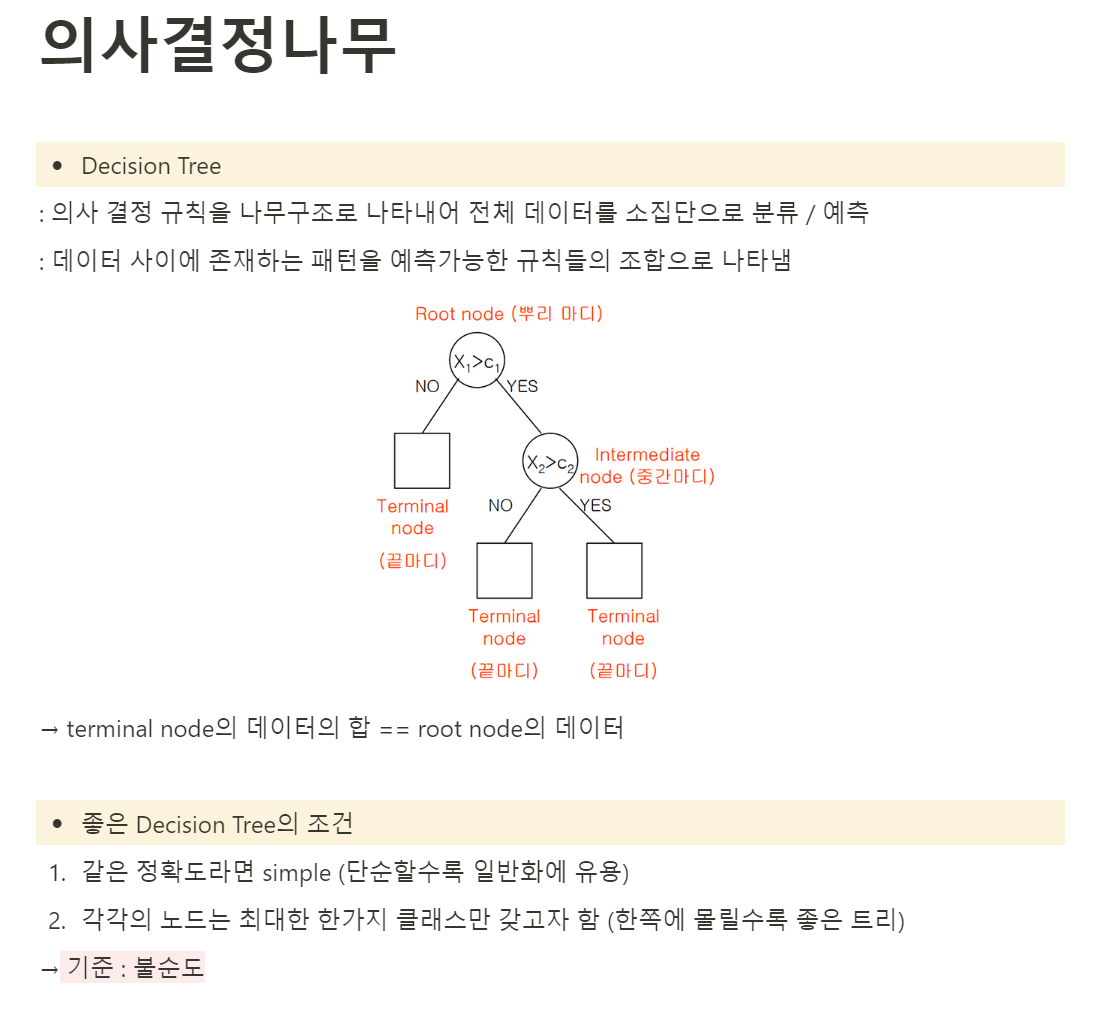

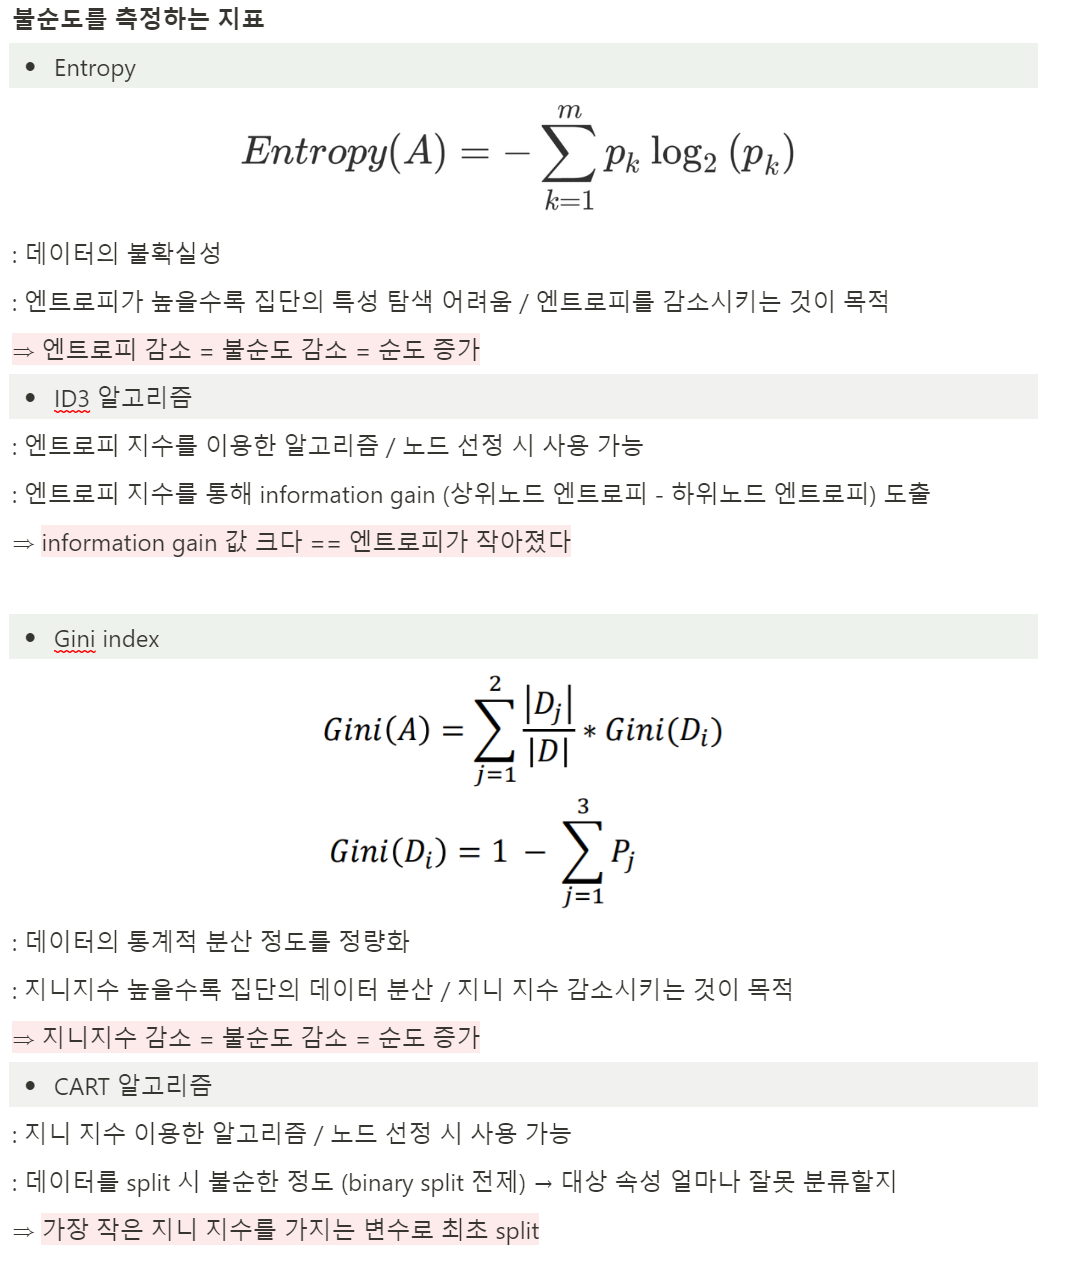

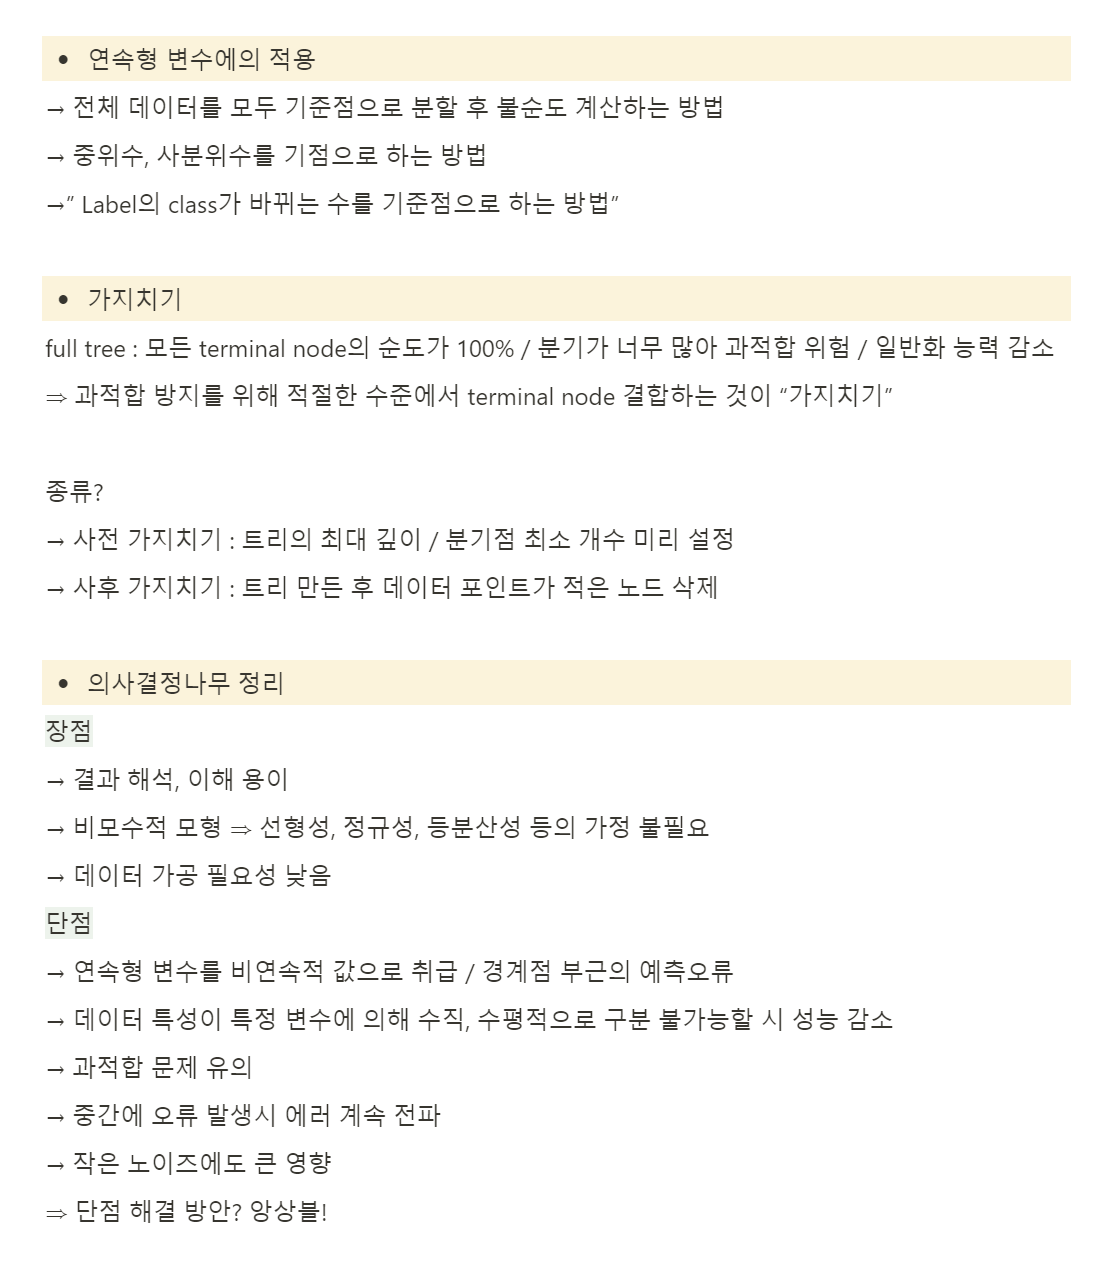